In [1]:
import cpr_gym
import itertools
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import time
import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count())

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-32-g0f6e80f-dirty (engine: v0.7.0-27-g5283549-dirty)
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: v0.7.0-27-g5283549-dirty


In [2]:
# Fix model import
import sys
import experiments.train.cfg_model as cfg_model

sys.modules[
    "cfg_model"
] = cfg_model  # cfg_model should be moved somewhere else, I guess

In [3]:
protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)
episode_len = 2048
n_episodes = 25
batches = [
    "2023-01-10_tailstorm-8-constant",
    # "2023-01-11_nakamoto", # broken, is it because is was trained on python3.11?
    "2023-01-11_bk-8",
    "2023-01-12_nakamoto",
]


def env_fn(x, episode_len=episode_len):
    env = gym.make(
        "cpr_gym:cpr-v0",
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
        episode_len=episode_len,
    )
    return env

# Data generation

## Find trained models

In [4]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)
            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reused=False)
models

,protocol,k,reward,subblock_selection,alpha,gamma,policy,path,kind,reused
0,tailstorm,8,constant,heuristic,0.45,0.05,ppo-34puppqa-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
1,tailstorm,8,constant,heuristic,0.40,0.50,ppo-3b53smc8-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
2,tailstorm,8,constant,heuristic,0.33,0.05,ppo-59cts654-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
3,tailstorm,8,constant,heuristic,0.40,0.95,ppo-2v40l8pu-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
4,tailstorm,8,constant,heuristic,0.45,0.50,ppo-1nxt1w3o-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
5,tailstorm,8,constant,heuristic,0.40,0.05,ppo-1ikc24dq-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
6,tailstorm,8,constant,heuristic,0.33,0.95,ppo-1l34subw-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
7,tailstorm,8,constant,heuristic,0.45,0.95,ppo-1r5preq2-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
8,tailstorm,8,constant,heuristic,0.33,0.50,ppo-1g8agtrz-best,data/models/2023-01-10_tailstorm-8-constant/pp...,trained,False
9,bk,8,constant,n/a,0.45,0.50,ppo-158w46c9-last,data/models/2023-01-11_bk-8/ppo-bk-8-alpha45-g...,trained,False


In [5]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reused=True, reward="discount"
        ),
    ]
)
# models

## Find hard-coded policies

In [6]:
def hard_coded_policies(models):
    for _idx, x in models[
        ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
    ].iterrows():
        env = env_fn(x)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reused=False)
)
hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

,protocol,k,reward,subblock_selection,policy,kind,path,reused
0,tailstorm,8,constant,heuristic,override-catchup,hard-coded,n/a,False
1,tailstorm,8,constant,heuristic,override-block,hard-coded,n/a,False
2,tailstorm,8,constant,heuristic,release-block,hard-coded,n/a,False
3,tailstorm,8,constant,heuristic,honest,hard-coded,n/a,False
36,bk,8,constant,n/a,selfish,hard-coded,n/a,False
37,bk,8,constant,n/a,honest,hard-coded,n/a,False
72,nakamoto,1,constant,n/a,sapirshtein-2016-sm1,hard-coded,n/a,False
73,nakamoto,1,constant,n/a,eyal-sirer-2014,hard-coded,n/a,False
74,nakamoto,1,constant,n/a,simple,hard-coded,n/a,False
75,nakamoto,1,constant,n/a,honest,hard-coded,n/a,False


## Run simulations

In [7]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    return pd.Series(
        {
            k: info[k]
            for k in [
                "episode_reward_attacker",
                "episode_chain_time",
                "episode_progress",
            ]
        }
    )


def measure_trained(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


def measure_hardcoded(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


def measure(x, **kwargs):
    if x.kind == "trained":
        return measure_trained(x, **kwargs)
    if x.kind == "hard-coded":
        return measure_hardcoded(x, **kwargs)
    assert False


# run simulations or restore from cached file

digest = hex(abs(hash(tuple([episode_len] + pd.util.hash_pandas_object(episodes)))))
fname = f"data/rl-eval-episodes-{digest}.pkl"
try:
    episodes = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = episodes.apply(
    results = episodes.parallel_apply(
        measure,
        axis=1,
    )
    episodes = pd.concat([episodes, results], axis=1)
    episodes.to_pickle(fname)
    episodes.columns

restore from data/rl-eval-episodes-0x7df364672e6c1757.pkl


# Find optimal policies

In [8]:
scenario = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "kind"]
policy = ["policy", "reused", "path"]
d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

,protocol,k,reward,subblock_selection,alpha,gamma,kind,policy,reused
0,bk,8,constant,n/a,0.33,0.05,hard-coded,honest,False
1,bk,8,constant,n/a,0.33,0.05,trained,ppo-1ya6n60a-last,False
2,bk,8,constant,n/a,0.33,0.50,hard-coded,honest,False
3,bk,8,constant,n/a,0.33,0.50,trained,ppo-1g36b612-best,False
4,bk,8,constant,n/a,0.33,0.95,hard-coded,honest,False
...,...,...,...,...,...,...,...,...,...
67,tailstorm,8,discount,heuristic,0.45,0.05,trained,ppo-34puppqa-best,True
68,tailstorm,8,discount,heuristic,0.45,0.50,hard-coded,override-block,False
69,tailstorm,8,discount,heuristic,0.45,0.50,trained,ppo-1nxt1w3o-best,True
70,tailstorm,8,discount,heuristic,0.45,0.95,hard-coded,override-block,False


# Compare RL against best hard-coded

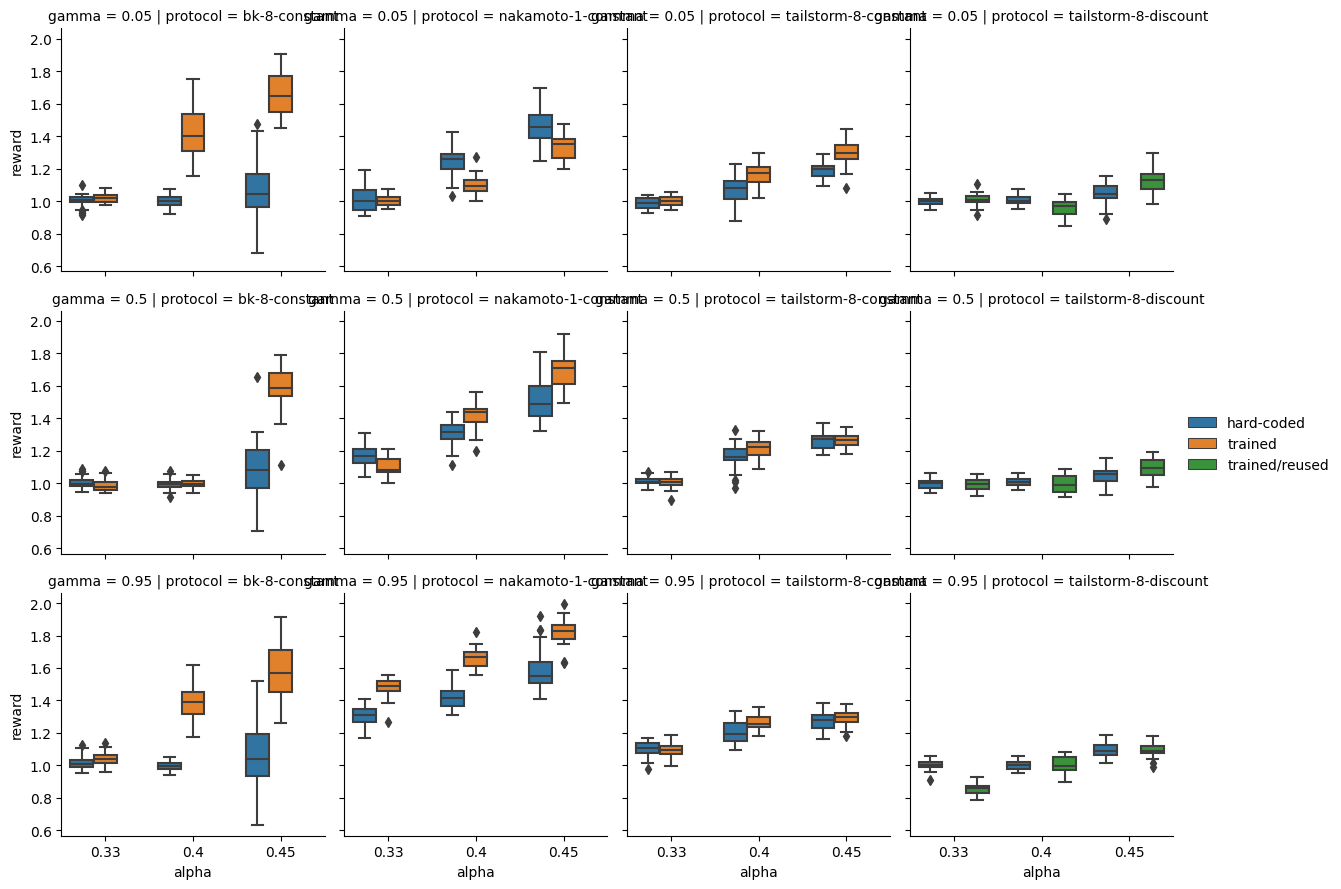

In [9]:
def rl_vs_hard_coded(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(data=d, col="protocol", row="gamma")
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

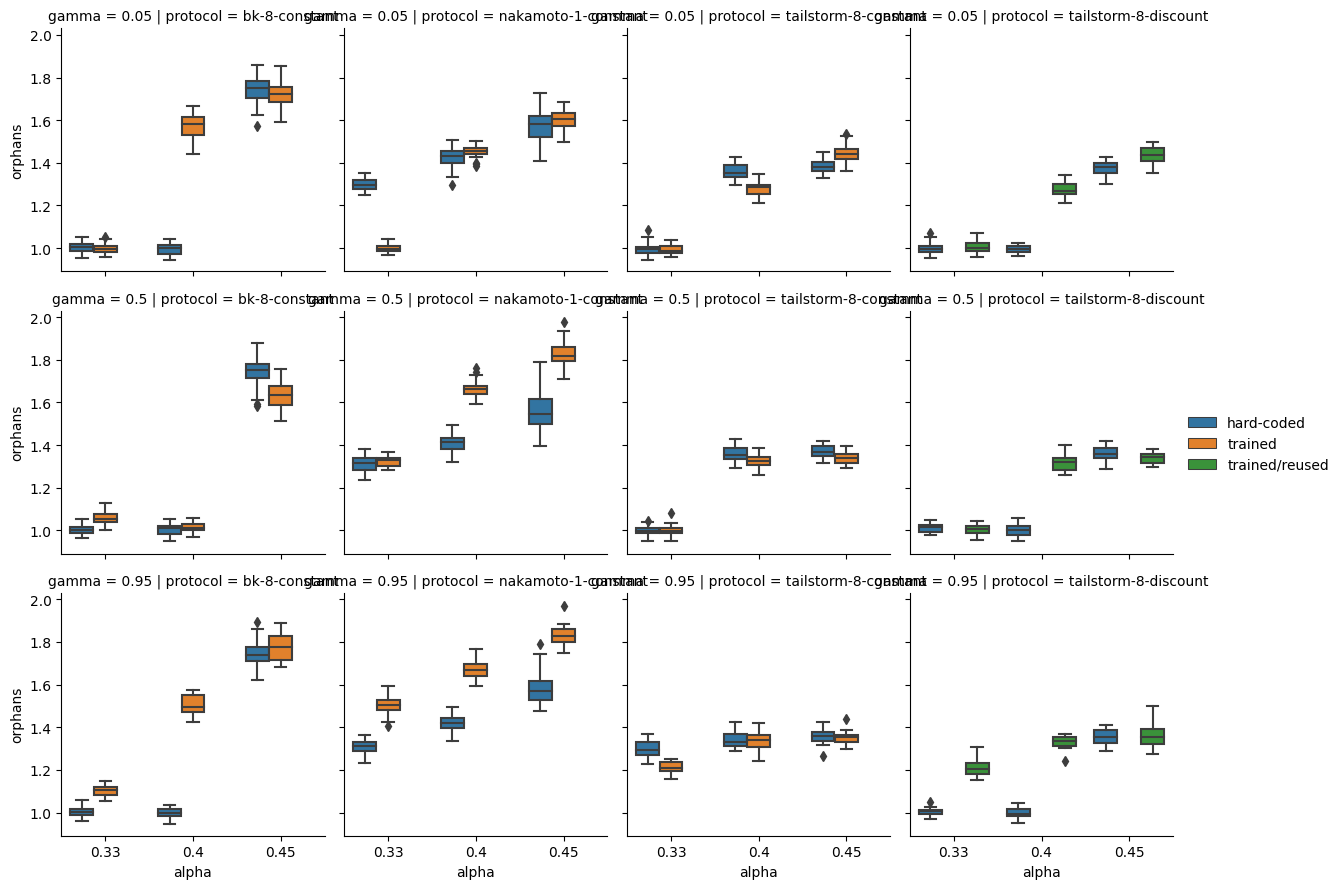

In [10]:
rl_vs_hard_coded(lambda d: d.episode_chain_time / d.episode_progress, "orphans")

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [11]:
scenario = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
policy = ["policy", "reused", "path"]
d = opt_episodes
d = d.assign(orphan_rate=d.episode_chain_time / d.episode_progress)
d = d.query("orphan_rate > 1.1")
be_means = d.groupby(scenario + policy + ["alpha"], as_index=False).alpha.mean()
# display(be_means.policy.drop_duplicates().reset_index(drop=True))

be_policies = be_means.loc[be_means.groupby(scenario).alpha.idxmin()].reset_index(
    drop=True
)
display(be_policies.drop(columns="path"))

,protocol,k,reward,subblock_selection,gamma,kind,policy,reused,alpha
0,bk,8,constant,n/a,0.05,hard-coded,selfish,False,0.45
1,bk,8,constant,n/a,0.05,trained,ppo-249vrvf3-last,False,0.40
2,bk,8,constant,n/a,0.50,hard-coded,selfish,False,0.45
3,bk,8,constant,n/a,0.50,trained,ppo-1g36b612-best,False,0.33
4,bk,8,constant,n/a,0.95,hard-coded,selfish,False,0.45
5,bk,8,constant,n/a,0.95,trained,ppo-bmip54l2-last,False,0.33
6,nakamoto,1,constant,n/a,0.05,hard-coded,sapirshtein-2016-sm1,False,0.33
7,nakamoto,1,constant,n/a,0.05,trained,ppo-3f0ydwtv-last,False,0.40
8,nakamoto,1,constant,n/a,0.50,hard-coded,sapirshtein-2016-sm1,False,0.33
9,nakamoto,1,constant,n/a,0.50,trained,ppo-2xvcyzfp-last,False,0.33


In [12]:
import io
import skopt
import skopt.plots
from skopt.space import Real
from skopt.utils import use_named_args

alpha = [0.1, 0.5]
dimensions = [Real(name="alpha", low=min(alpha), high=max(alpha))]
n_calls = 42
be_episode_len = 8192


def objective_fn(policy):
    @use_named_args(dimensions=dimensions)
    def fn(alpha):
        x = policy.copy()
        x["alpha"] = alpha
        r = measure(
            x,
            env_fn=lambda x: env_fn(x, episode_len=be_episode_len),
            pretend_alpha=policy.alpha,
        )
        return np.abs(
            (r["episode_reward_attacker"] / r["episode_progress"] / alpha) - 1
        )

    return fn


def png_of_optimization(x, res, break_even):
    fig = plt.figure()
    ax = skopt.plots.plot_gaussian_process(res)
    ax.axvline(break_even, linestyle="solid", label="minimum/break-even")
    ax.axvline(res.x[0], linestyle="dashed", label="minimal observation")
    ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("α")
    ax.set_ylabel("f(α)")
    ax.set_title(
        f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    )
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    plt.close()
    buf.seek(0)
    return buf.getvalue()


def break_even_of_res(res):
    # res.x gives argmin of observation
    # the observations are stochastic, hence we cannot use res.x
    # revert last surrogate function instead
    # surrogate has support 0..1, thus transform alphas
    return res.x_iters[
        np.argmin(
            res.models[-1].predict(
                (res.x_iters - min(alpha)) / (max(alpha) - min(alpha))
            )
        )
    ][0]


def find_break_even(x):
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", "The objective has been evaluated at this point before"
        )
        res = skopt.gp_minimize(objective_fn(x), dimensions, n_calls=n_calls)
        break_even = break_even_of_res(res)
        # optimizer result cannot be pickled
        # thus create plot here and save in dataframe
        png = png_of_optimization(x, res, break_even)
    return pd.Series(dict(break_even=break_even, break_even_png=png))


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[7]]
d = be_policies

digest = hex(
    abs(hash(tuple([be_episode_len, n_calls] + list(pd.util.hash_pandas_object(d)))))
)
fname = f"data/rl-eval-break-even-points-{digest}.pkl"
try:
    be_points = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = d.progress_apply(
    results = d.parallel_apply(
        find_break_even,
        axis=1,
    )
    be_points = pd.concat([d, results], axis=1)
    be_points.to_pickle(fname)

restore from data/rl-eval-break-even-points-0x5a290d79f0c92559.pkl


In [13]:
be_points.drop(columns=["path", "break_even_png"])

,protocol,k,reward,subblock_selection,gamma,kind,policy,reused,alpha,break_even
0,bk,8,constant,n/a,0.05,hard-coded,selfish,False,0.45,0.442739
1,bk,8,constant,n/a,0.05,trained,ppo-249vrvf3-last,False,0.40,0.297328
2,bk,8,constant,n/a,0.50,hard-coded,selfish,False,0.45,0.441030
3,bk,8,constant,n/a,0.50,trained,ppo-1g36b612-best,False,0.33,0.383198
4,bk,8,constant,n/a,0.95,hard-coded,selfish,False,0.45,0.448204
5,bk,8,constant,n/a,0.95,trained,ppo-bmip54l2-last,False,0.33,0.234259
6,nakamoto,1,constant,n/a,0.05,hard-coded,sapirshtein-2016-sm1,False,0.33,0.323490
7,nakamoto,1,constant,n/a,0.05,trained,ppo-3f0ydwtv-last,False,0.40,0.380722
8,nakamoto,1,constant,n/a,0.50,hard-coded,sapirshtein-2016-sm1,False,0.33,0.246532
9,nakamoto,1,constant,n/a,0.50,trained,ppo-2xvcyzfp-last,False,0.33,0.280369


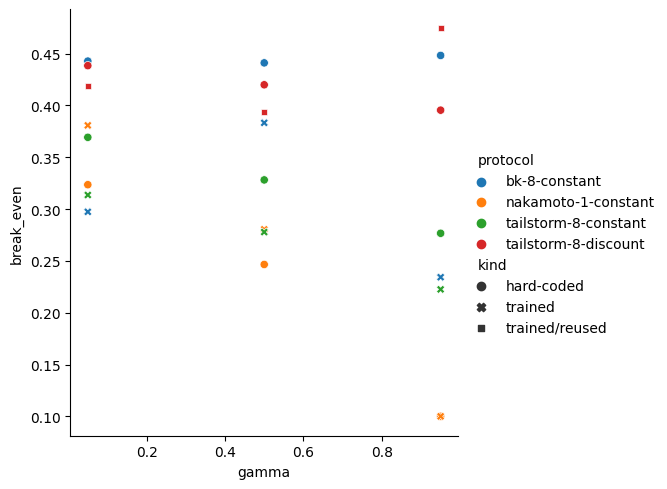

In [14]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

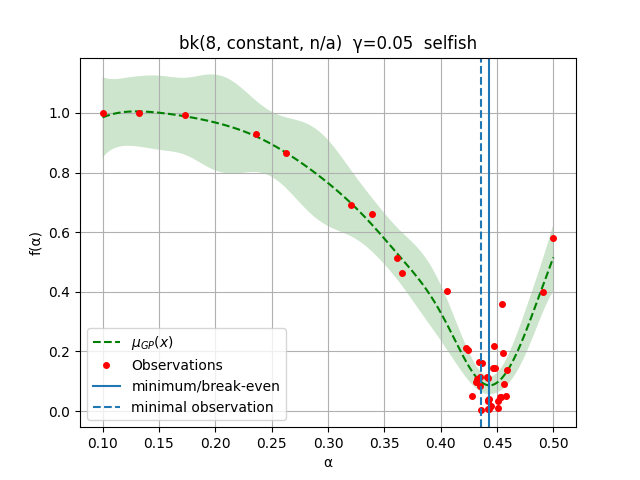

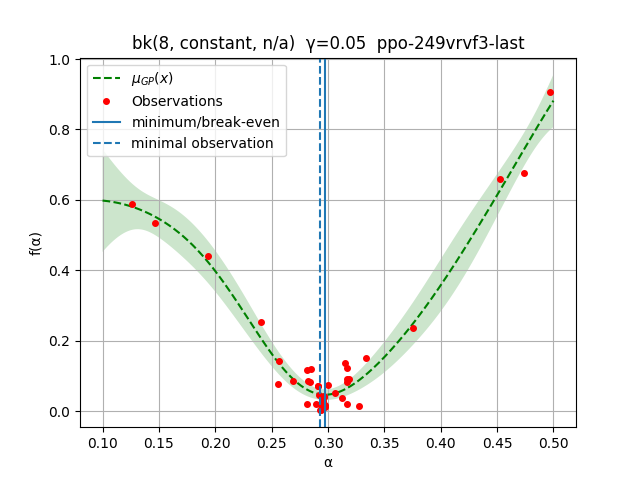

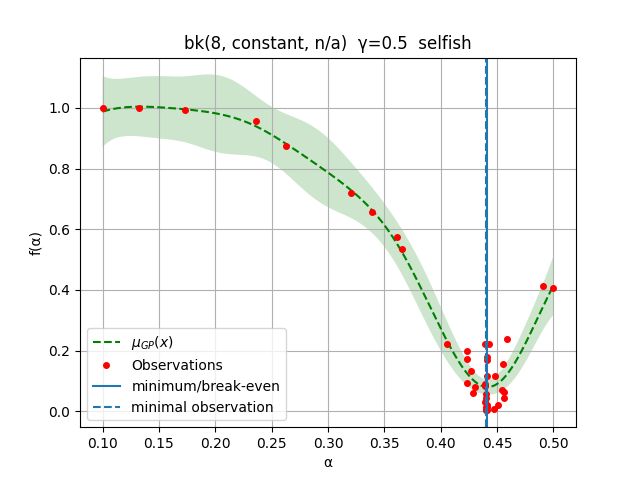

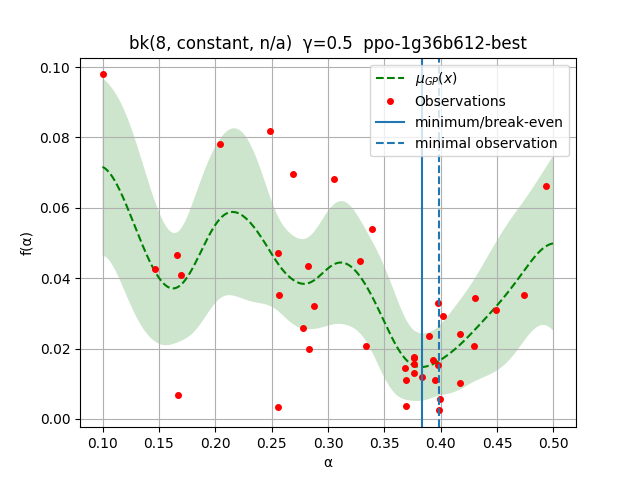

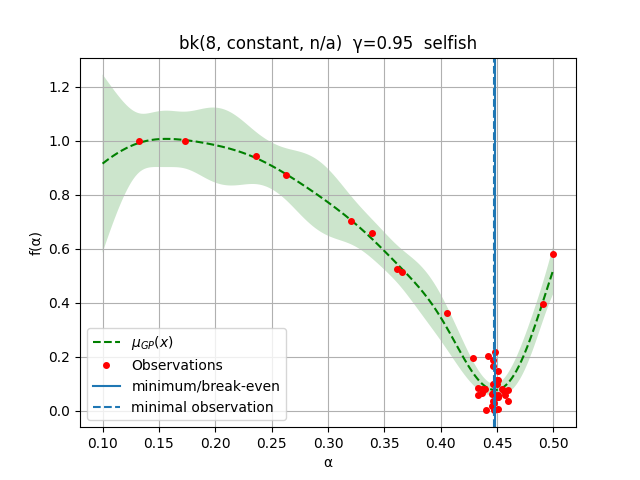

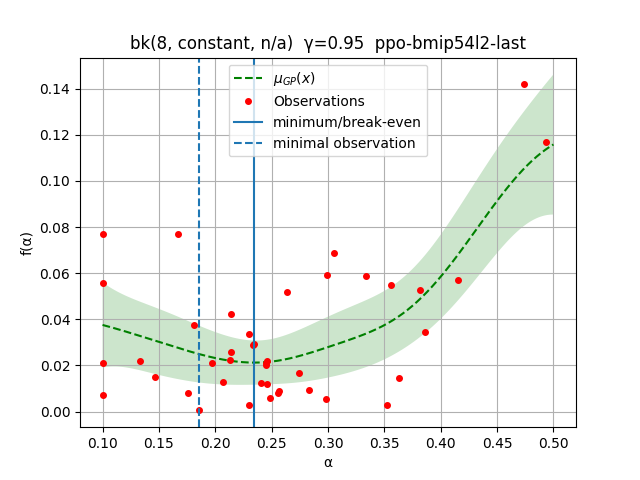

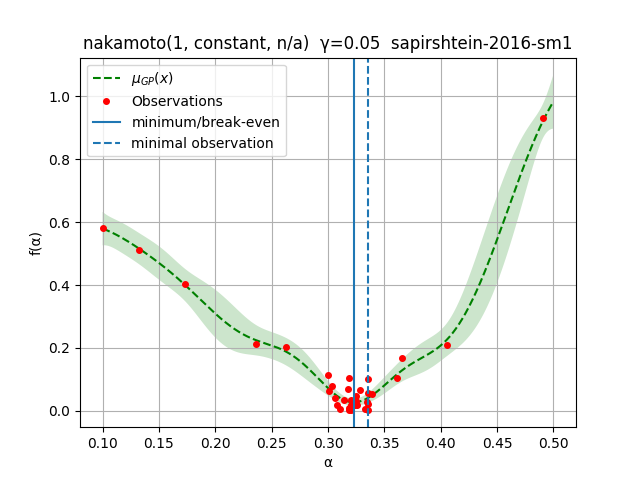

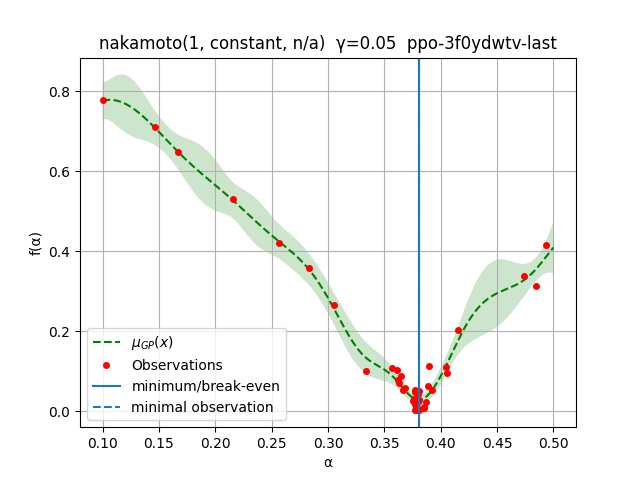

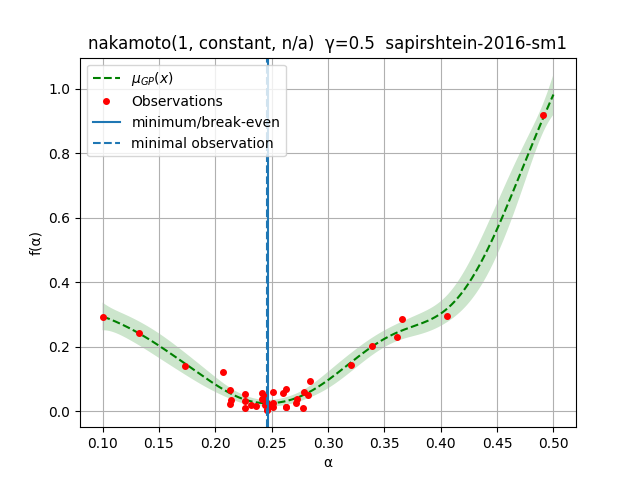

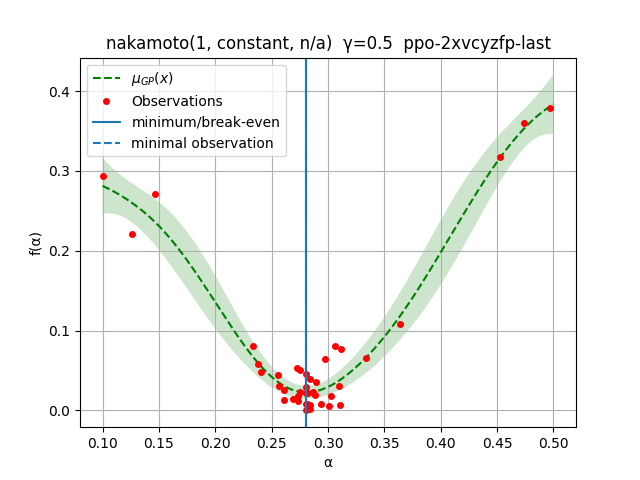

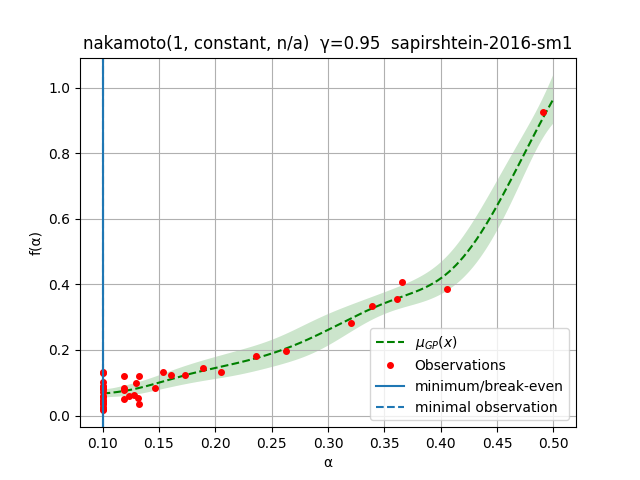

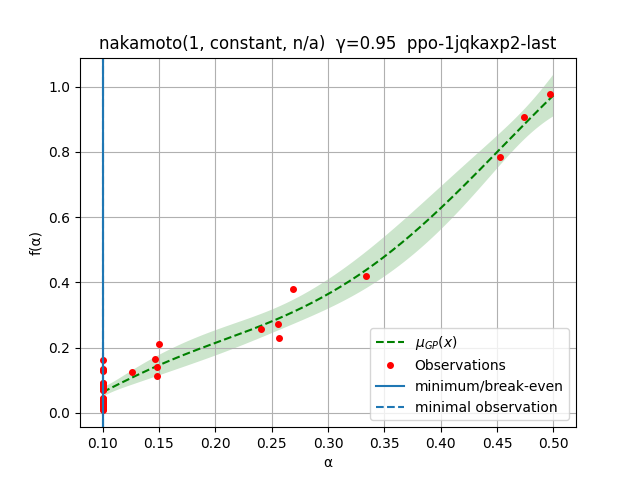

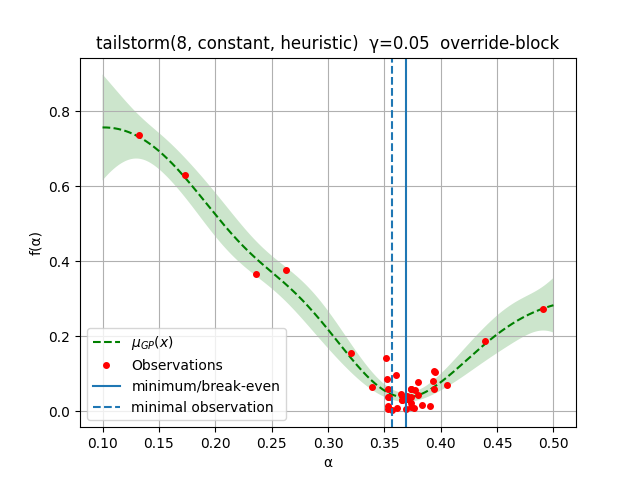

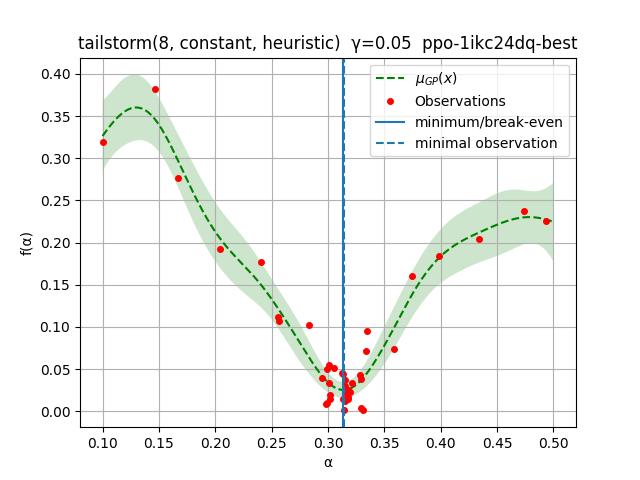

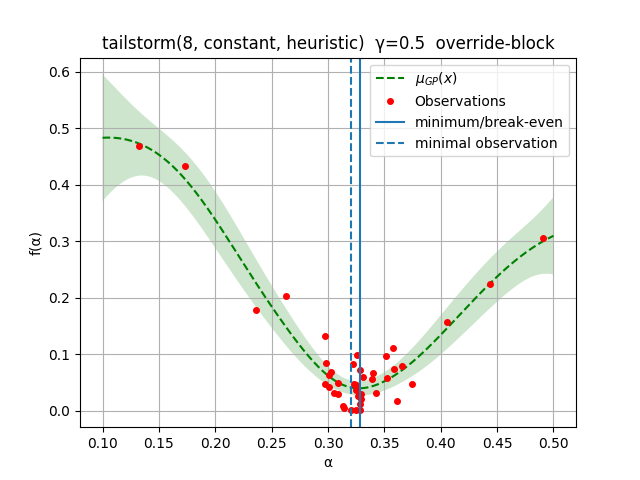

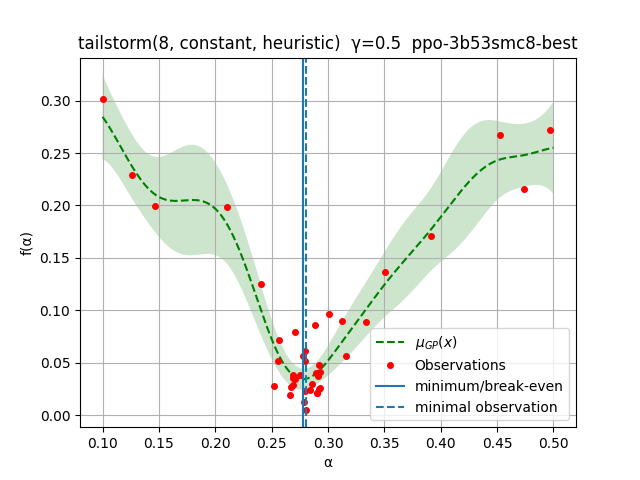

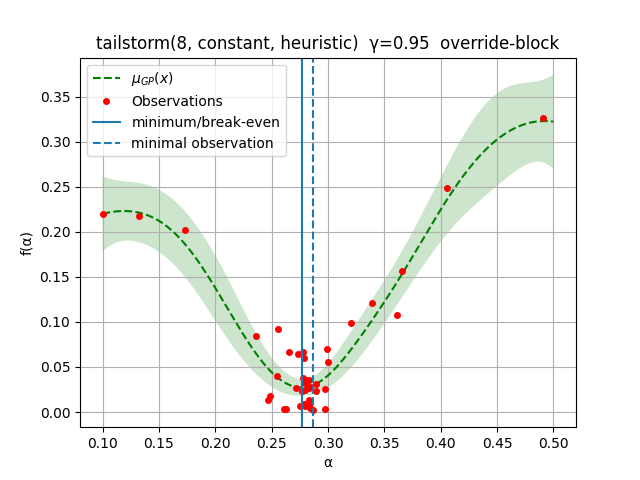

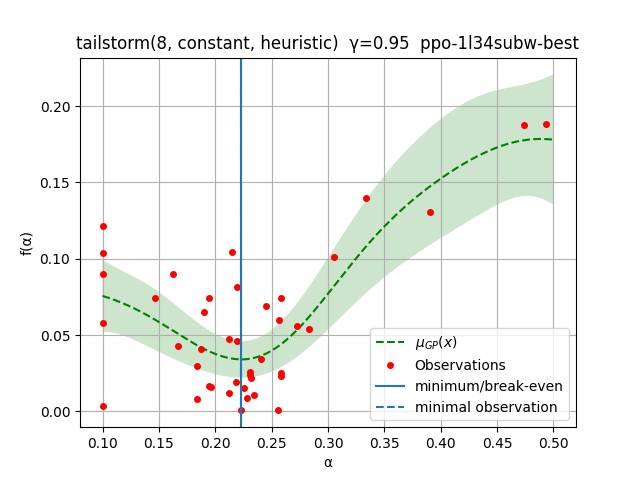

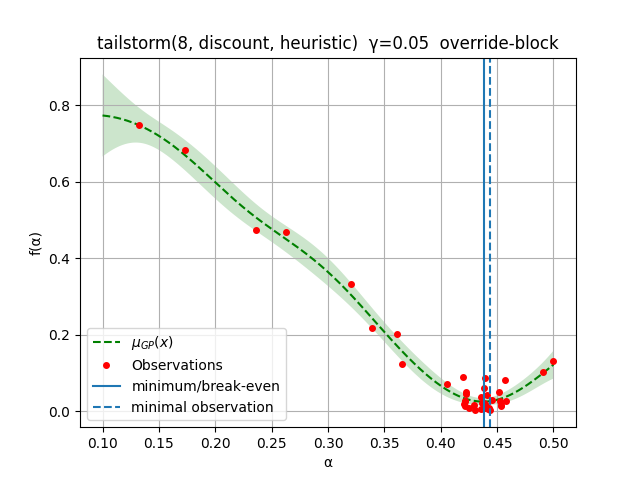

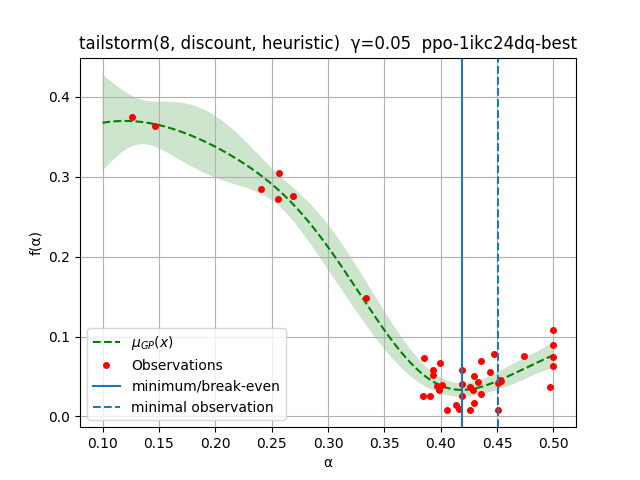

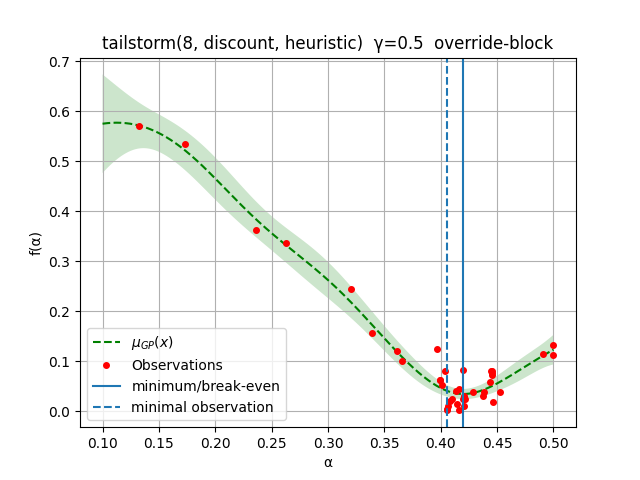

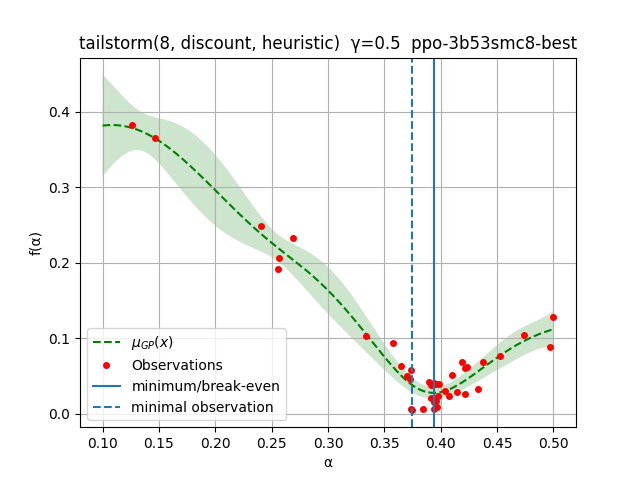

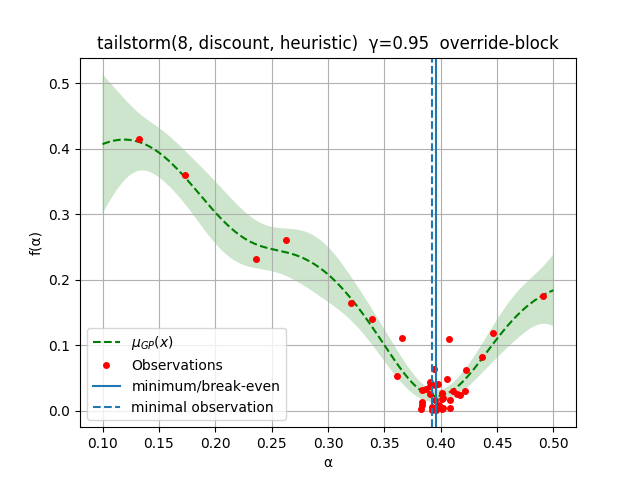

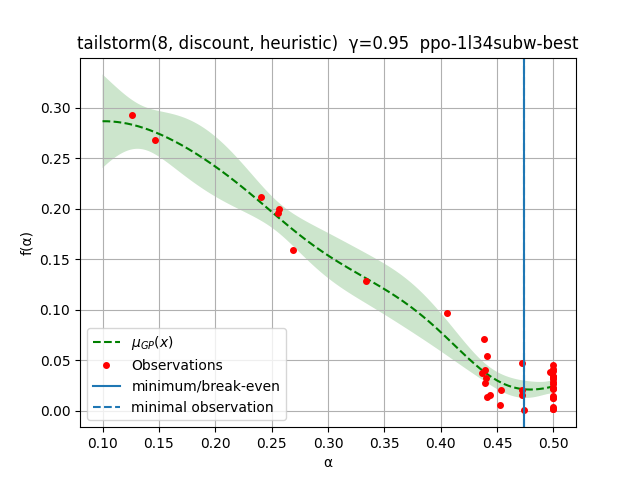

In [15]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)